In [1]:
play = False

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18 as cosmo

import utils as ut
import props as p
import lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

#TIM = p.SpaceTIM
TIM = p.TIM
#TIM = p.TIM2
#GAL = p.AstroDeep
GAL = p.Euclid
CII = l.CII

In [2]:
def quadsum(arr):
    return np.sqrt(np.sum(arr[~np.isnan(arr)]**2))

def galCross_Variance(ngal, numModes, Px, Pg, Pl, Nl):
    crossVar = [(PxG**2 + (NT + PT) * (1/n_gal + Pg)) / (2*nm)
        for n_gal, nm, PxG, Pg, PT, NT in zip(ngal, numModes, Px, Pg, Pl, Nl)]
    return crossVar

In [104]:
dummy = [1,1,1,1]
N = len(nGals)
crossvar = np.zeros(N)
for i in np.arange(N):
    ng = nGals[i]*np.ones(4)
    crossvar[i] = galCross_Variance(ng, dummy, dummy, dummy, dummy, dummy)[0]

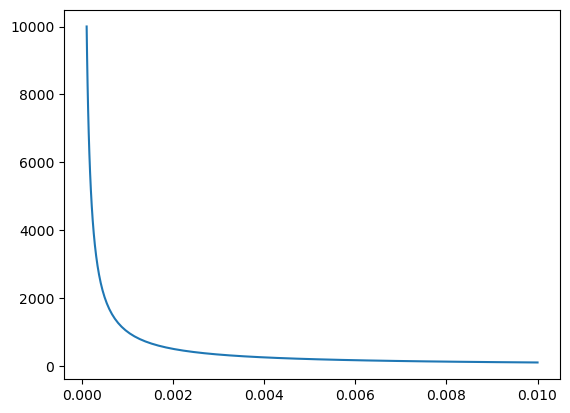

In [106]:
plt.plot(nGals, crossvar)

In [3]:
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 0.8

if play:
    dlnk = 1

colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bin_zs = [b.center.value for b in bins]
bands = ['SW', 'SW', 'LW', 'LW'] 

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

In [4]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]


# resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=False) 


results = camb.get_results(pars)

binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

nModes = []
for j, (ks,ws) in enumerate(zip(k_mags, windows)):
    kflat = ks.flatten()
    wflat = ws.flatten()
    kNonZero = kflat[np.nonzero(kflat)[0]]
    edges = kbin_edges[j]
    
    nModeList = []
    for i in np.arange(len(edges)-1):
        #print(i, len(edges))
        if i+1 == len(edges):
            wSum = (np.sum(wflat[kflat>edges[i]]))
        else:
            wSum = (np.sum(wflat[(kflat>edges[i]) & (kflat<=edges[i+1])]))
        nModeList.append(wSum/2.) # accounting for double counting.
    nModeList = np.asarray(nModeList)
    nModes.append(np.asarray(nModeList))

window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([CII.Inu(sfrd, z).value for sfrd, z in zip(sfrds, bin_zs)])

fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
b_CII = 1.7 # TODO: Get an actual value for this and Bgal
b_gal = 1.7 # maintaining b* = b_CII*b_gal = 3
Igal = 1
bstar = b_CII*b_gal

C:\Users\jaguirre\AppData\Local\Temp\ipykernel_14884\1290356114.py:13: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


Note: redshifts have been re-sorted (earliest first)


## Make changes in the cell below

In [107]:
def quadSNR(SWNEI, LWNEI, numberDensities):
    '''
    Calculate the quadature sum of SNR(k) for 4 seperate TIM z bins as a function of TIM NEI and galaxy nGal

    SWNEI: Average Noise equivalent intensity of the short wavelength array in u.Jy / (u.s ** .5)
    LWNEI: Average Noise equivalent intensity of the long wavelength array in u.Jy / (u.s ** .5)
    nGal: len 4 arr - Galaxy number density in Mpc**-3 * h**3 per TIM redshift bin in order of lowest to highest z

    returns quad_SNRs: len 4 arr quadature sum of SNR(k) for 4 TIM z bins in order of lewst to highest z
    '''
    TIM.SW.NEI = SWNEI # These don't actually change the NEI in the noise calculation
    TIM.LW.NEI = LWNEI
    GAL.n_gals = numberDensities
    
    TIM['SW'].ins.NEI = SWNEI
    TIM['LW'].ins.NEI = LWNEI
    
    # ***
    #for b, band in zip(bins, bands):
    #    print(TIM[band].ins.NEI)
    
    LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

    x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
    #where fs is SFRD from the catalogue divided by the corresponding madau dickinson curve point.
    PxGs = [(bstar * Icii * Igal * Pm) #+ x_shot 
                for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]


    TIM_shot = [1.2e9,2.2e9,3e9,3e9] # TODO: Discuss a self consistent way of calculating these values.
    P_TIM = [(b_CII**2 * ICII**2 * Pm + shot) for ICII, (_,Pm), shot in zip(Iciis, Pms, TIM_shot)]
    N_TIM = [lsb.cell_noise(TIM.time).value for lsb, nm in zip(LSbins, nModes)]
    #print(N_TIM[0])
    P_gal = [b_gal**2*Pm for (_,Pm), ngal in zip(Pms, GAL.n_gals)]

    VARx = galCross_Variance(GAL.n_gals, nModes, PxGs, P_gal, P_TIM, N_TIM)
    SNR_PxG = [PxG / np.sqrt(VARs)  for PxG, VARs in zip(PxGs, VARx)]
    
    #sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
    quad_SNRs = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_PxG]

    
    return quad_SNRs

In [108]:
quadSNR(1*u.Jy/np.power(u.s,1/2), 2*u.Jy/np.power(u.s,1/2), [3, 3, 3, 3])

5.370505478225324e-05


[22.09046846283531, 20.389602246076784, 24.678435866680662, 25.363122671385824]

In [109]:
npoints = 50

#NEIs = np.linspace( 1.191e6, 6.81e7, npoints) * u.Jy / (u.s ** .5)
#nGals = np.linspace(1e-4, 1e-2, npoints)
NEIs = np.logspace( np.log10(1.191e6), np.log10(6.81e7), npoints+1) * u.Jy / (u.s ** .5)
nGals = np.logspace(np.log10(1e-4), np.log10(1e-2), npoints)
calcSNRs = np.zeros((len(NEIs), len(nGals)))

In [110]:
for i, NEI in enumerate(NEIs):
    for j, n in enumerate(nGals):
        nArray = np.asarray([n,n,n,n])
        #print(n, NEI)
        calcSNRs[i][j] = quadSNR(NEI, NEI, nArray)[0]

76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
76179599.81258546
89562890.41967972
89562890.41967972
89562890.41967972
89562890.41967972
89562890.41967972
89562890.4

278069911.73754245
278069911.73754245
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
326921447.4115032
384355258.394548
384355258.394548
384355258.394548
384355258.3

1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1402969207.511842
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.4799683
1649443915.47996

6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
6020781483.78205
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
7078516999.2941065
70

25837922515.59221
25837922515.59221
25837922515.59221
25837922515.59221
25837922515.59221
25837922515.59221
25837922515.59221
25837922515.59221
25837922515.59221
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30377148588.720337
30

130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
130362215203.15848
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
153264349298.6463
1532643492

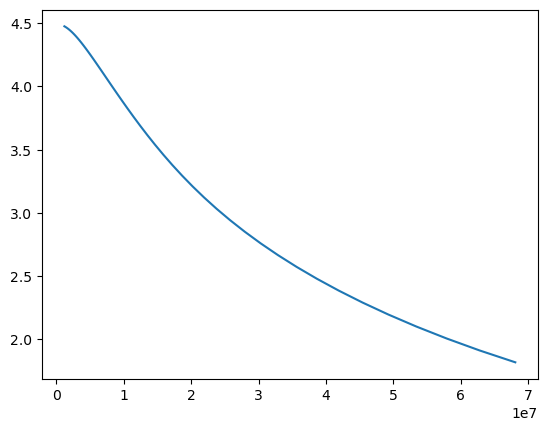

In [111]:
plt.plot(NEIs, calcSNRs[:, 0])

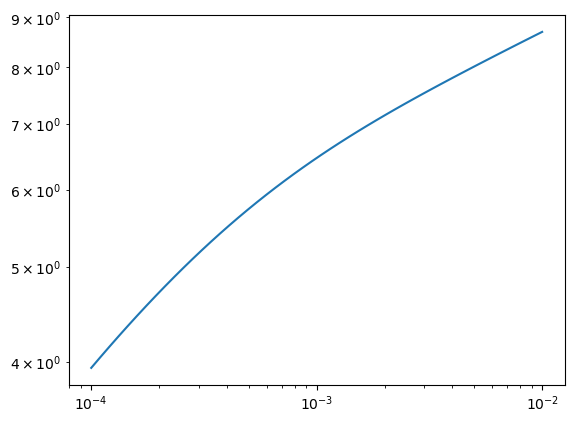

In [112]:
plt.loglog(nGals, calcSNRs[25, :])

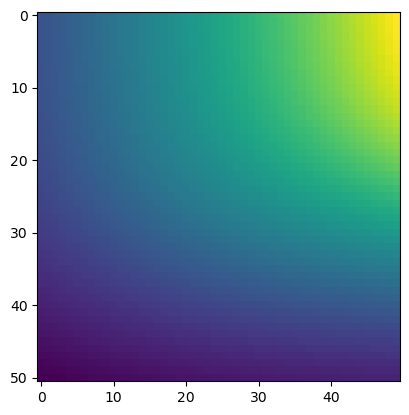

In [113]:
plt.imshow(calcSNRs)

In [114]:
plt.contour

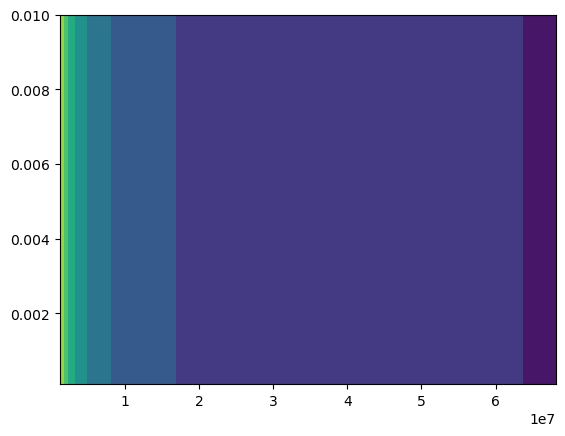

In [16]:
plt.contourf(xv.value, yv, calcSNRs)

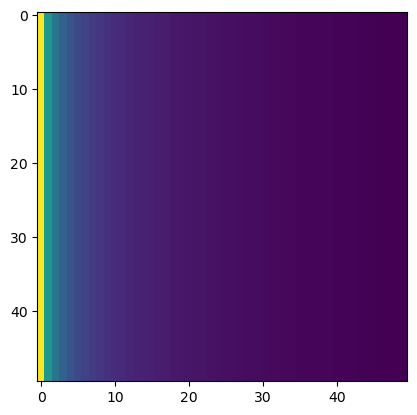

In [60]:
plt.imshow(calcSNRs)


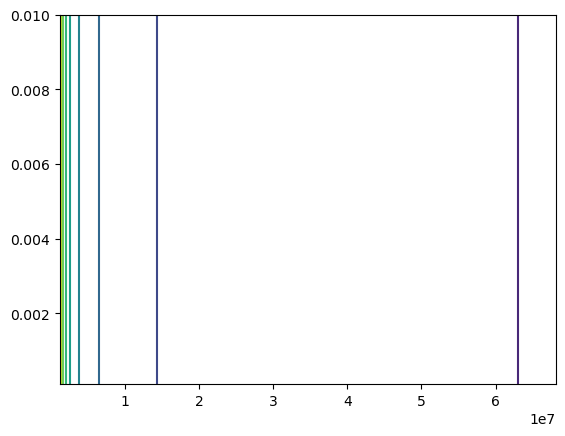

In [46]:
plt.contour(NEIs, nGals, calcSNRs)

In [33]:
calcSNRs

array([[43.22482396, 17.8218743 , 13.23306736, 11.02763173,  9.67304085,
         8.73538217,  8.03815942,  7.49430844,  7.05528673,  6.69161805,
         6.38423694,  6.12019605,  5.89035517,  5.68805446,  5.50831199,
         5.34731733,  5.20210002,  5.07030598,  4.9500425 ,  4.83976832],
       [43.22482396, 17.8218743 , 13.23306736, 11.02763173,  9.67304085,
         8.73538217,  8.03815942,  7.49430844,  7.05528673,  6.69161805,
         6.38423694,  6.12019605,  5.89035517,  5.68805446,  5.50831199,
         5.34731733,  5.20210002,  5.07030598,  4.9500425 ,  4.83976832],
       [43.22482396, 17.8218743 , 13.23306736, 11.02763173,  9.67304085,
         8.73538217,  8.03815942,  7.49430844,  7.05528673,  6.69161805,
         6.38423694,  6.12019605,  5.89035517,  5.68805446,  5.50831199,
         5.34731733,  5.20210002,  5.07030598,  4.9500425 ,  4.83976832],
       [43.22482396, 17.8218743 , 13.23306736, 11.02763173,  9.67304085,
         8.73538217,  8.03815942,  7.49430844,  

In [20]:
nGalList = np.logspace(-5, -2, 50)
SNRx_as_nGal = np.zeros(len(nGalList))

for i,n in enumerate(nGalList):
    x_shot = fs * Iciis[2] / n # cross shot for TIMxGal
    Pcross = (bstar * Iciis[2] * Igal * Pms[2][1]) + x_shots[2]
    
    VARxTIM = (Pcross**2 + (N_TIM[2] + P_TIM[2]) * (1/n +P_gal[2])) / (2*nModes[2])
    
    SNRx_as_nGal[i] = quadsum(Pcross / np.sqrt(VARxTIM))

In [22]:
quad_SNRs

[4.1738935189346495, 3.5692162416809086, 5.965722950868964, 5.121272514248967]